### README

- Error: Root Mean Squared Error
- Predict Target:

Item sales for the month immediately after the data in sales_train.csv, which is November 2015:

DAILY_SALES=pd.read_csv('sales_train.csv')
DAILY_SALES['date_dt']=pd.to_datetime(DAILY_SALES['date'],format="%d.%m.%Y")
print(DAILY_SALES.date_dt.max())
> Timestamp('2015-10-31 00:00:00')

You want to predict the total sales for that month, i.e. one number for each shop/item pair in the test.csv file.

In [197]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%precision 4
%reload_ext autoreload

import re
import sys
import math
import random
import datetime
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
import warnings


warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'%.4f'

In [4]:
from scrd_tool import feature_engineering, evaluation

In [14]:
#step1: input data source

from pathlib import Path

cwd = Path.cwd()

# cwd.parent point to project root folder
items  = pd.read_csv(cwd.parent / 'input/items.csv')
train = pd.read_csv(cwd.parent / 'input/sales_train.csv')
test = pd.read_csv(cwd.parent / 'input/test.csv')
item_category = pd.read_csv(cwd.parent / 'input/item_categories.csv')
shops = pd.read_csv(cwd.parent / 'input/shops.csv')

In [117]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [177]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [119]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [118]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [189]:
df = pd.merge(train, items, how='left', left_on=['item_id'], right_on=['item_id'],
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-01-09,20,54,0,58.0,1.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,2014-04-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
2,2014-02-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
3,2014-06-07,18,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
4,2014-04-08,19,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76


## Feature Engineering

In [18]:
train['date'].max()

'31.12.2014'

In [186]:
len(np.unique(test[['shop_id', 'item_id']], axis=0))
np.unique(test[['shop_id', 'item_id']], axis=0)

214200

array([[    2,    30],
       [    2,    31],
       [    2,    32],
       ...,
       [   59, 22164],
       [   59, 22166],
       [   59, 22167]], dtype=int64)

In [188]:
feature_engineering.run(train)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


records count are:  2935849
duplicated:  6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-01-05,16,50,3423,999.0,1.0
1866340,2014-12-07,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


null check: 
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [192]:
feature_engineering.run(df)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-01-09,20,54,0,58.0,1.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,2014-04-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
2,2014-02-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
3,2014-06-07,18,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
4,2014-04-08,19,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


records count are:  2935849
duplicated:  6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
512421,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512489,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512722,2014-01-05,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512961,2014-12-07,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
2713052,2013-05-01,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40
2867357,2014-12-31,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37


null check: 
date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64


date item_price


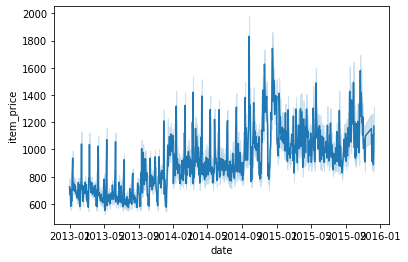

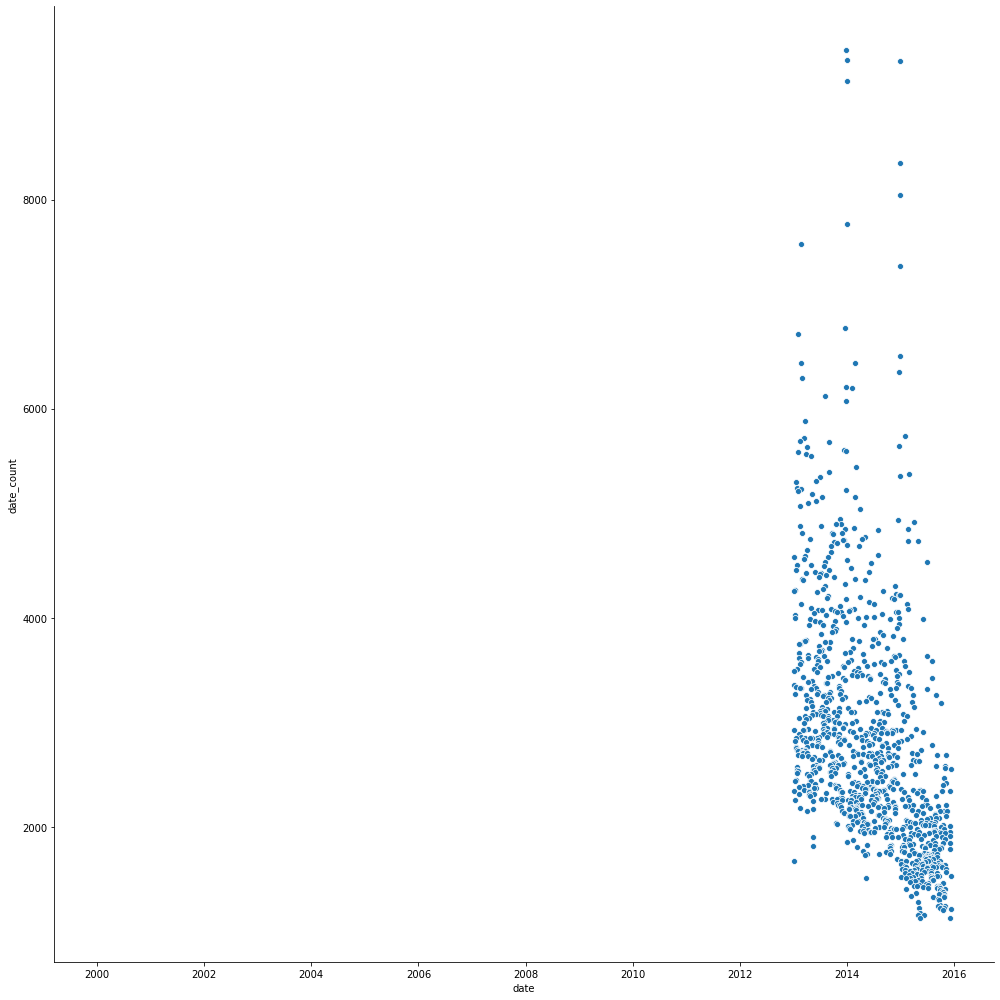

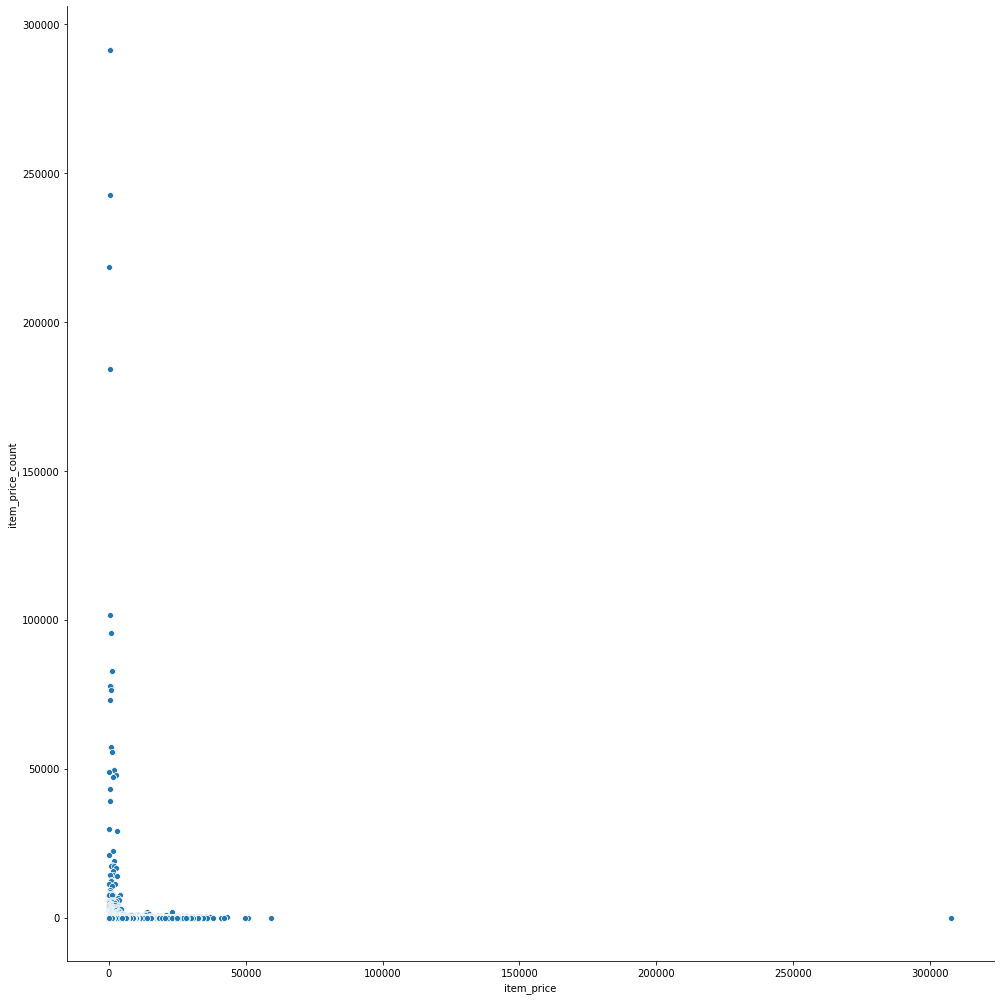

In [175]:
feature_engineering.show(train, display_columns=['date', 'item_price'])

In [203]:
feature_engineering.run(df, category_columns=['shop_id', 'item_id', 'item_category_id'], datetime_columns=['date'])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2014-01-09,20,54,0,58.0,1.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,2014-04-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
2,2014-02-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
3,2014-06-07,18,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76
4,2014-04-08,19,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


records count are:  2935849
duplicated:  6


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
512421,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512489,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512722,2014-01-05,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
512961,2014-12-07,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
2713052,2013-05-01,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40
2867357,2014-12-31,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37


null check: 
date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_name           0
item_category_id    0
dtype: int64


### Outlier Detection

In [194]:
# -1 and 307980 looks like outliers, let's delete them
print('before train shape:', train.shape)
train = train[(train.item_price > 0) & (train.item_price < 300000)]
print('after train shape:', train.shape)

before train shape: (2935849, 6)
after train shape: (2935847, 6)


Text(0.5, 0, 'Item Price')

Text(0.5, 1.0, 'Original Distiribution')

Text(0.5, 0, 'Item Price')

Text(0.5, 1.0, 'log1p Transformation')

C:\Users\albert.chen\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


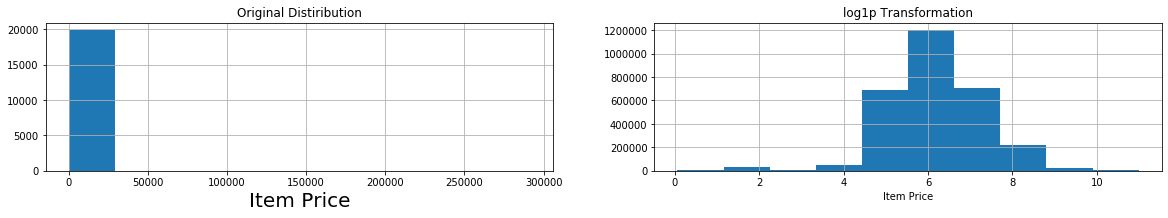

In [195]:
count_price = train.item_price.value_counts().sort_index(ascending=False)
plt.subplot(221)
count_price.hist(figsize=(20,6))
plt.xlabel('Item Price', fontsize=20);
plt.title('Original Distiribution')

plt.subplot(222)
train.item_price.map(np.log1p).hist(figsize=(20,6))
plt.xlabel('Item Price');
plt.title('log1p Transformation')
train.loc[:,'item_price'] = train.item_price.map(np.log1p)

In [205]:
df['item_price_log'] = df.apply(lambda x: np.log1p(x['item_price']), axis=1)
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_price_log
0,2014-01-09,20,54,0,58.0,1.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,4.077537
1,2014-04-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
2,2014-02-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
3,2014-06-07,18,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
4,2014-04-08,19,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831


In [212]:
df.dtypes

date                datetime64[ns]
date_block_num      int64         
shop_id             category      
item_id             category      
item_price          float64       
item_cnt_day        float64       
item_name           object        
item_category_id    category      
item_price_log      float64       
dtype: object

In [234]:
df[['shop_id', 'item_id']]

,shop_id,item_id
0,54,0
1,55,1
2,55,1
3,55,1
4,55,1
...,...,...
2935844,42,22168
2935845,16,22168
2935846,43,22168
2935847,12,22168


In [252]:
df.dtypes

date                datetime64[ns]
date_block_num      int64         
shop_id             category      
item_id             category      
item_price          float64       
item_cnt_day        float64       
item_name           object        
item_category_id    category      
item_price_log      float64       
dtype: object

shop_id item_price_log
datetime time display
item_price_log
show count shop_id
show count item_price_log


<Figure size 432x288 with 0 Axes>

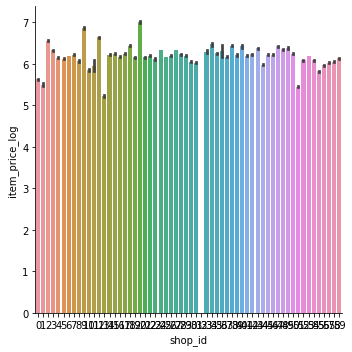

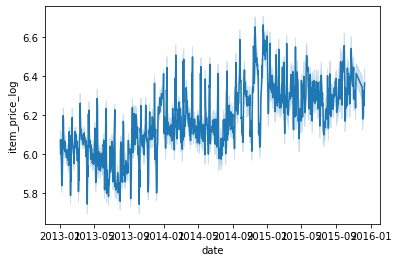

<Figure size 432x288 with 0 Axes>

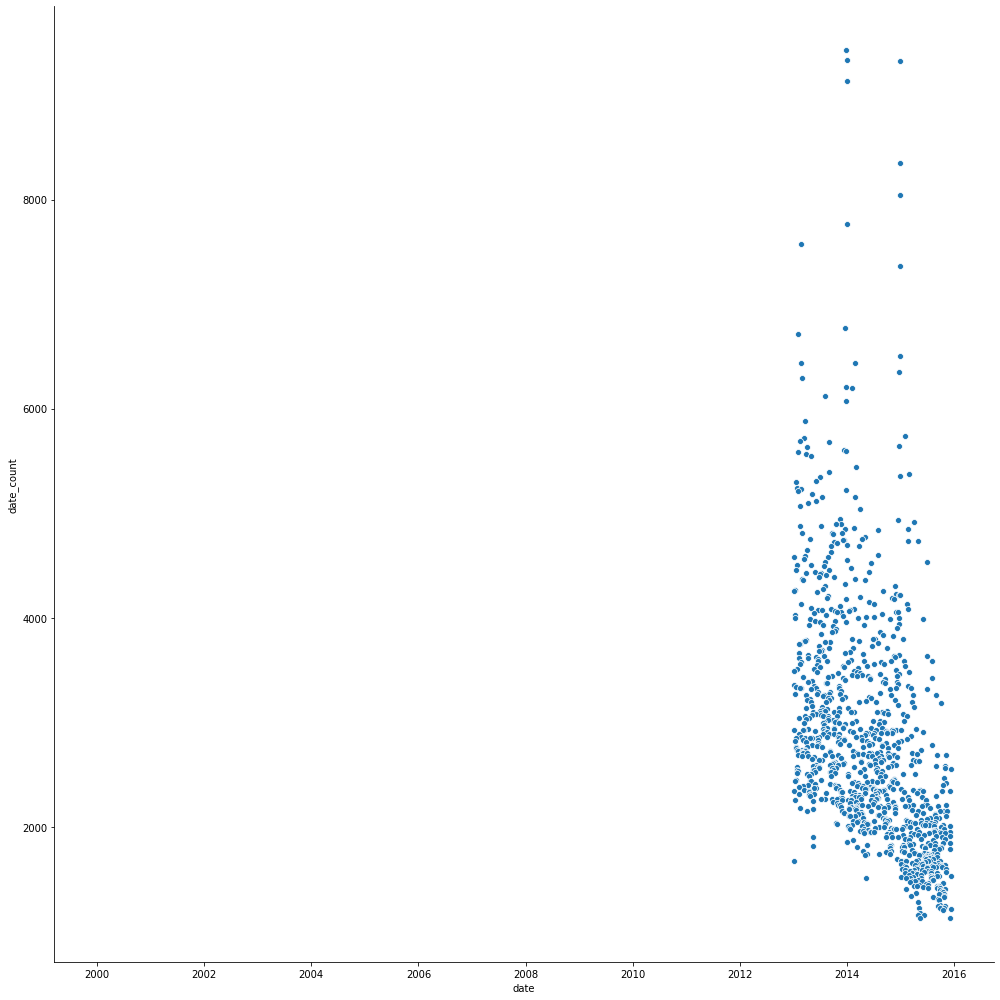

<Figure size 432x288 with 0 Axes>

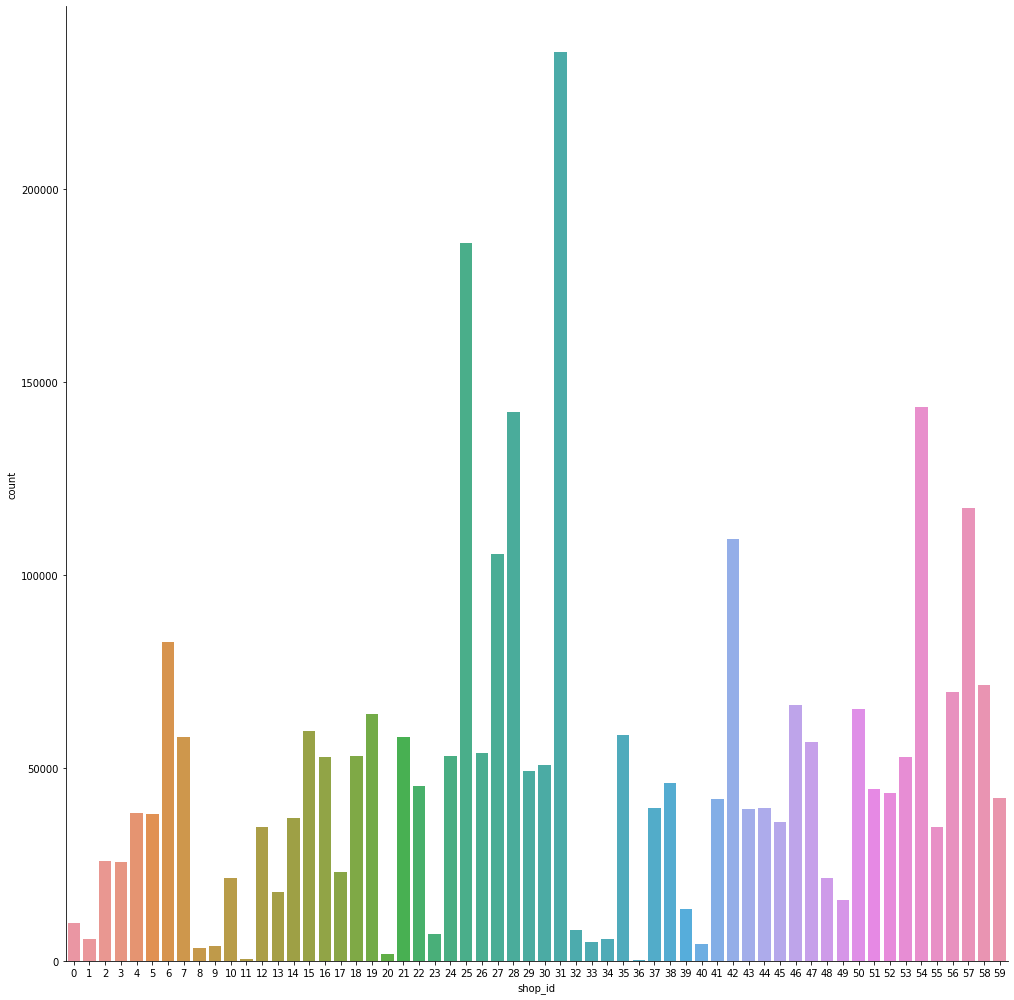

<Figure size 432x288 with 0 Axes>

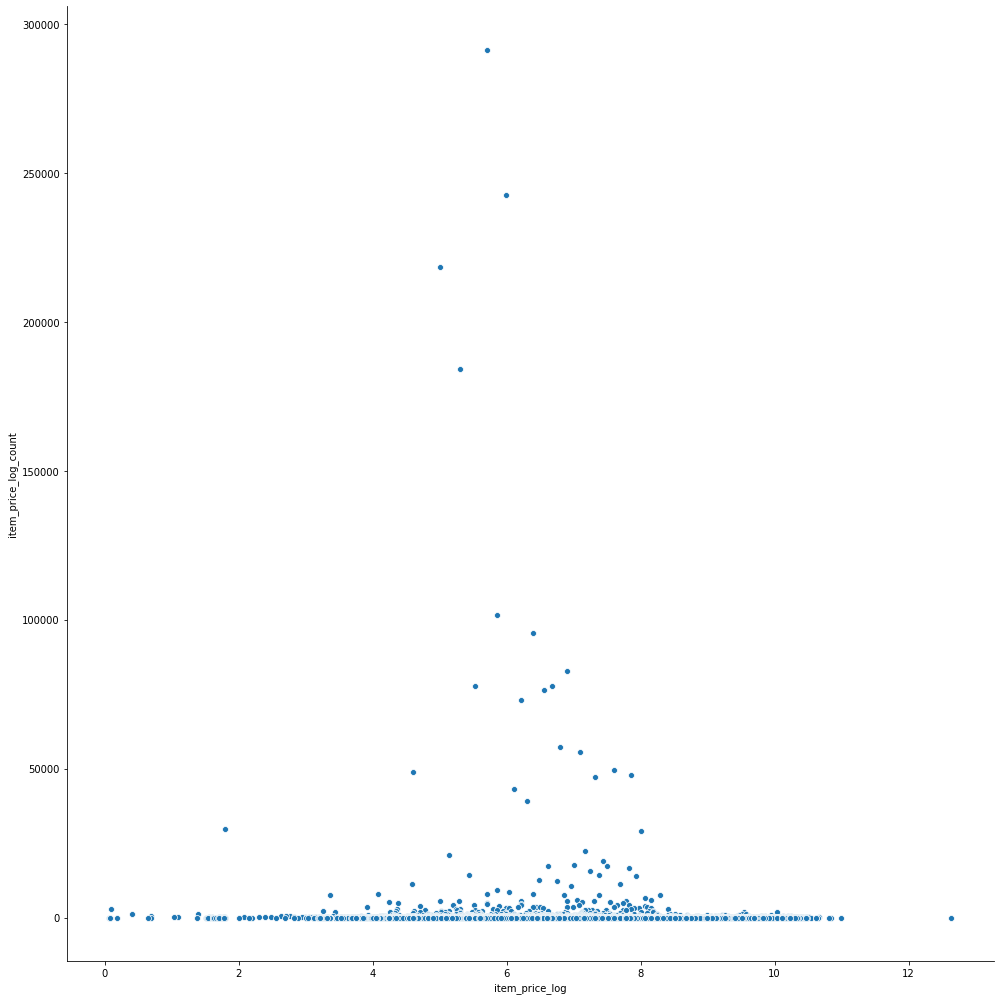

In [256]:
feature_engineering.show(df, display_columns=['date', 'shop_id', 'item_price_log'])

item_price_log


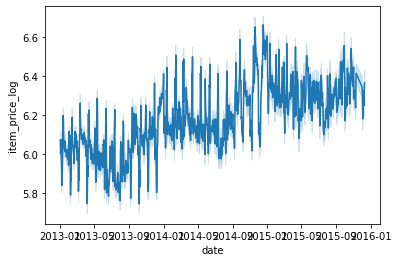

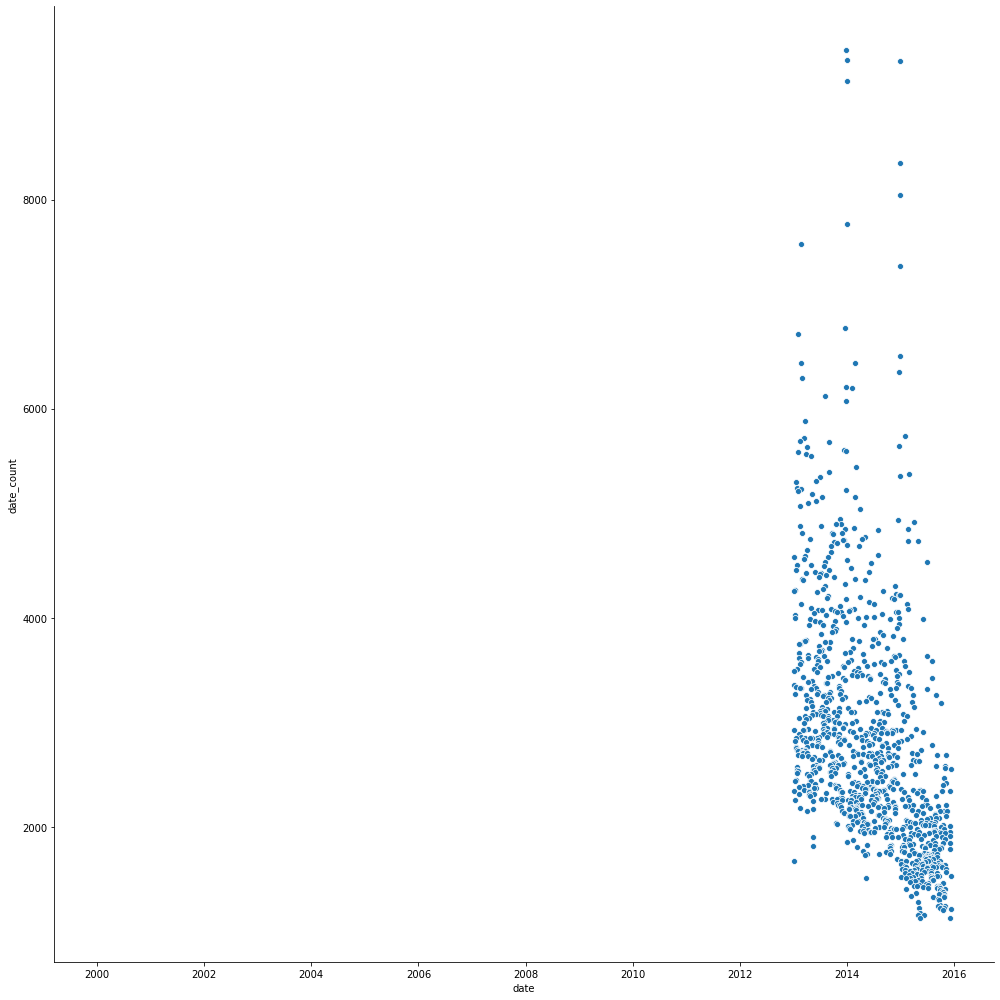

In [248]:
feature_engineering.show_x_is_datetime(df, 'date', ['item_price_log'])

### pivot to time series format

In [258]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_price_log
0,2014-01-09,20,54,0,58.0,1.0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,4.077537
1,2014-04-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
2,2014-02-04,15,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
3,2014-06-07,18,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831
4,2014-04-08,19,55,1,4490.0,1.0,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",76,8.409831


In [257]:
## Pivot by monht to wide format
p_df = df.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum')
p_df.head()

date_block_num     0     1   2   3   4   5   6   7   8   9  ...  24  25  26  \
shop_id item_id                                             ...               
0       30      NaN   31.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
        31      NaN   11.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
        32       6.0  10.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
        33       3.0  3.0  NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
        35       1.0  14.0 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   

date_block_num   27  28  29  30  31  32  33  
shop_id item_id                              
0       30      NaN NaN NaN NaN NaN NaN NaN  
        31      NaN NaN NaN NaN NaN NaN NaN  
        32      NaN NaN NaN NaN NaN NaN NaN  
        33      NaN NaN NaN NaN NaN NaN NaN  
        35      NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 34 columns]

In [259]:
p_df = p_df.fillna(0.0)
p_df.head()

date_block_num     0     1    2    3    4    5    6    7    8    9  ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0  3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [12]:
## Pivot by monht to wide format
p_df = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
p_df.head()

date_block_num    0     1    2    3    4  ...    29   30   31   32   33
shop_id item_id                           ...                          
0       30       0.0  31.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        31       0.0  11.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        32       6.0  10.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        33       3.0   3.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0
        35       1.0  14.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0  0.0

[5 rows x 34 columns]

In [15]:
# Encode Categories
from sklearn import preprocessing

number = preprocessing.LabelEncoder()
train_cleaned_df[['cats']] = number.fit_transform(train_cleaned_df.cats)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'cats'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,cats,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,54,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,54,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,54,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Building

In [280]:
p_df.head()

date_block_num     0     1    2    3    4    5    6    7    8    9  ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0  3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [283]:
p_df.iloc[:, (p_df.columns != 33)]

date_block_num     0     1    2    3    4    5    6    7    8    9  ...   23  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0  3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22154    1.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22155    0.0  0.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    24   25   26   27   28   29   30   31   32  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22155    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    0.0  9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  
        22164    0.0  2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[424124 rows x 33 columns]

In [263]:
train_cleaned_df = p_df
import xgboost as xgb
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

1.2947565268634924


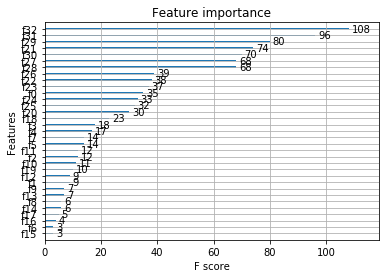

In [264]:
xgb.plot_importance(bst)

In [265]:
apply_df = test
apply_df['shop_id']= apply_df.shop_id.astype('str')
apply_df['item_id']= apply_df.item_id.astype('str')

apply_df = test.merge(train_cleaned_df, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
apply_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [269]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,"!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]",1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [271]:
items.dtypes

item_name           object  
item_id             int64   
item_category_id    category
dtype: object

In [273]:
apply_df['item_id'] = apply_df['item_id'].astype('int')

In [274]:
apply_df = pd.merge(apply_df, items[['item_id']], left_on=['item_id'], right_on=['item_id'], how='left')
apply_df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,26,27,28,29,30,31,32,33,item_name,item_category_id
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ONE DIRECTION Made In The A.M.,55
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русская версия]",19
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, русская версия]",23
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Need for Speed [PS4, русская версия]",20


In [292]:
apply_df.iloc[:, list(range(3, 36))]

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [294]:
preds = bst.predict(xgb.DMatrix(apply_df.iloc[:, list(range(3, 36))].values))

In [295]:
# Normalize prediction to [0-20]
preds = list(map(lambda x: min(20,max(x,0)), list(preds)))
sub_df = pd.DataFrame({'ID':apply_df.ID,'item_cnt_month': preds })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.139539
std,61834.358168,0.000000
min,0.000000,0.139539
25%,53549.750000,0.139539
50%,107099.500000,0.139539
75%,160649.250000,0.139539
max,214199.000000,0.139539


In [296]:
sub_df.to_csv('Submission_Predict Sales.csv',index=False)